In [1]:
#!curl -LO https://github.com/alexeygrigorev/dino-or-dragon/releases/download/data/dino-dragon.zip

In [2]:
#!unzip dino-dragon

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
import numpy as np
import os

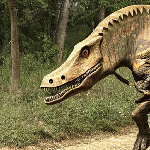

In [4]:
input_size = 150
path = 'train/dino'
filename = 'ffac40c7-80c6-4f9f-8236-cc324fa04d70.jpg'
img = load_img(os.path.join(path,filename), target_size=(input_size,input_size))
img

In [5]:
# Xception usage example
'''
model = Xception(weights="imagenet", input_shape=(input_size,input_size,3))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
y = model.predict(X)
y.shape
decode_predictions(y)
train_gen = ImageDataGenerator(
                preprocessing_function=preprocess_input,
                rotation_range=90,
                width_shift_range=10,
                height_shift_range=10,
                shear_range=10,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True)
train_ds = train_gen.flow_from_directory('./train', 
                                         target_size=(input_size,input_size),
                                        batch_size=32,
                                        )
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory('./test', 
                                         target_size=(input_size,input_size),
                                        batch_size=32,
                                         shuffle=False
                                        )
X, y = next(train_ds)
model.predict(X)
'''

In [6]:
train_gen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=90,
                width_shift_range=10,
                height_shift_range=10,
                shear_range=10,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True)

In [7]:
train_ds = train_gen.flow_from_directory('./train', 
                                         target_size=(input_size,input_size),
                                        batch_size=32,
                                        )

Found 1594 images belonging to 2 classes.


In [8]:
train_ds.class_indices

{'dino': 0, 'dragon': 1}

In [9]:
X, y = next(train_ds)

In [10]:
X

array([[[[0.18143895, 0.13581751, 0.44666824],
         [0.18856974, 0.13938291, 0.45736444],
         [0.19835825, 0.14737786, 0.46894652],
         ...,
         [0.1632503 , 0.39854443, 0.4377601 ],
         [0.16720977, 0.4025039 , 0.4417196 ],
         [0.16499949, 0.40029362, 0.4395093 ]],

        [[0.19101158, 0.14787433, 0.4537567 ],
         [0.1785327 , 0.13539545, 0.4412778 ],
         [0.18242304, 0.13630956, 0.44814438],
         ...,
         [0.16579086, 0.401085  , 0.44030067],
         [0.16783734, 0.40313146, 0.44234714],
         [0.16137399, 0.3966681 , 0.4358838 ]],

        [[0.18327041, 0.14013316, 0.4460155 ],
         [0.2017683 , 0.15863104, 0.46451342],
         [0.18928942, 0.14615215, 0.45203453],
         ...,
         [0.1676036 , 0.40289772, 0.44211343],
         [0.16421182, 0.39950597, 0.43872166],
         [0.15774846, 0.39304262, 0.4322583 ]],

        ...,

        [[0.13872112, 0.34264272, 0.38577998],
         [0.14255129, 0.3464729 , 0.38961014]

In [11]:
y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [12]:
val_gen = ImageDataGenerator(rescale=1./255)
val_ds = val_gen.flow_from_directory('./test', 
                                         target_size=(input_size,input_size),
                                        batch_size=32,
                                         shuffle=False
                                        )

Found 394 images belonging to 2 classes.


In [15]:
def make_model(base_model_type = 'custom', 
               input_size = 150, 
               learning_rate = 0.002, 
               num_classes = 2, 
               size_inner = 100, 
               drop_rate=0.2):
    
    inputs = keras.Input(shape=(input_size,input_size,3))

    if base_model_type == 'xception':
        base_model = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=(input_size,input_size,3))
        base_model.trainable = False
        base = base_model(inputs)
        vectors = keras.layers.GlobalAveragePooling2D()(base)
        inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
        drop = keras.layers.Dropout(drop_rate)(inner)
        outputs = keras.layers.Dense(num_classes)(drop)
        if num_classes <= 2:
            loss = keras.losses.BinaryCrossentropy(from_logits=True)
        elif num_classes > 2:
            loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    elif base_model_type == 'custom':
        conv2d_1 = keras.layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation='relu')(inputs)
        maxpool2d_1 = keras.layers.MaxPooling2D(
            pool_size=(2, 2))(conv2d_1)
        flatten_1 = tf.keras.layers.Flatten()(maxpool2d_1)
        dense_1 = tf.keras.layers.Dense(64, activation='relu')(flatten_1)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_1)
        loss = keras.losses.BinaryCrossentropy()
    else:
        print("Model not implemented.")
        return None
    
    model = keras.Model(inputs, outputs)

    #optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [16]:
'''
Question 1

Since we have a binary classification problem, what is the best loss function for us?

    binary crossentropy
    focal loss
    mean squared error
    categorical crossentropy

Note: since we specify an activation for the output layer, we don't need to set from_logits=True
'''
# A: binary crossentropy


"\nQuestion 1\n\nSince we have a binary classification problem, what is the best loss function for us?\n\n    binary crossentropy\n    focal loss\n    mean squared error\n    categorical crossentropy\n\nNote: since we specify an activation for the output layer, we don't need to set from_logits=True\n"

In [17]:
'''
Question 2

What's the total number of parameters of the model? You can use the summary method for that.

    9215873
    11215873
    14215873
    19215873
'''
model = make_model(base_model_type='custom')
model.summary()
# A: 11215873

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       


2022-11-14 23:06:04.656422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/mlzoomcamp/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
_________________________________________________________________


In [18]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5', 
                               save_best_only=True,
                              monitor='val_accuracy',
                              mode='max')
#model.save_weights('model_v1.h5', save_format='h5')

In [19]:
'''
Generators and Training

For the next two questions, use the following data generator for both train and validation:

ImageDataGenerator(rescale=1./255)

    We don't need to do any additional pre-processing for the images.
    When reading the data from train/val directories, check the class_mode parameter. Which value should it be for a binary classification problem?
    Use batch_size=20
    Use shuffle=True for both training and validation

For training use .fit() with the following params:

model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)
'''
train_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory('./train', 
                                         target_size=(input_size,input_size),
                                        batch_size=20,
                                         shuffle=True,
                                         class_mode='binary'
                                        )

val_gen = ImageDataGenerator(#preprocessing_function=preprocess_input,
                            rescale=1./255)
val_ds = val_gen.flow_from_directory('./test', 
                                         target_size=(input_size,input_size),
                                        batch_size=20,
                                         shuffle=True,
                                     class_mode='binary'
                                        )
X, y = next(train_ds)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


In [20]:
model = make_model(base_model_type='custom')
'''
history = model.fit(train_ds, 
                    epochs=2, 
                    validation_data=val_ds,
                   callbacks=[checkpoint_cb])
'''
history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds)

Epoch 1/10
80/80 [==============================] - 26s 313ms/step - loss: 0.5771 - accuracy: 0.6957 - val_loss: 0.5286 - val_accuracy: 0.7107
Epoch 2/10
80/80 [==============================] - 27s 335ms/step - loss: 0.4219 - accuracy: 0.8193 - val_loss: 0.3791 - val_accuracy: 0.8299
Epoch 3/10
80/80 [==============================] - 25s 310ms/step - loss: 0.3412 - accuracy: 0.8739 - val_loss: 0.3329 - val_accuracy: 0.8579
Epoch 4/10
80/80 [==============================] - 25s 308ms/step - loss: 0.3095 - accuracy: 0.8789 - val_loss: 0.3258 - val_accuracy: 0.8680
Epoch 5/10
80/80 [==============================] - 27s 333ms/step - loss: 0.2664 - accuracy: 0.9009 - val_loss: 0.3367 - val_accuracy: 0.8350
Epoch 6/10
80/80 [==============================] - 25s 316ms/step - loss: 0.2356 - accuracy: 0.9065 - val_loss: 0.3215 - val_accuracy: 0.8604
Epoch 7/10
80/80 [==============================] - 26s 325ms/step - loss: 0.2228 - accuracy: 0.9253 - val_loss: 0.2791 - val_accuracy: 0.8756

In [21]:
history.history['accuracy']
history.history['val_accuracy']

[0.710659921169281,
 0.8299492597579956,
 0.8578680157661438,
 0.8680202960968018,
 0.8350253701210022,
 0.8604061007499695,
 0.875634491443634,
 0.8832487463951111,
 0.8807106614112854,
 0.8832487463951111]

In [22]:
'''
Question 3

What is the median of training accuracy for all the epochs for this model?

    0.40
    0.60
    0.90
    0.20
'''
print("Median training accuracy: ", np.median(history.history['accuracy']))

Median training accuracy:  0.9037013947963715


In [23]:
'''
Question 4

What is the standard deviation of training loss for all the epochs for this model?

    0.11
    0.66
    0.99
    0.33
'''
print("STD training loss: ", np.std(history.history['loss']))

STD training loss:  0.12703139539736832


In [24]:
'''
Data Augmentation

For the next two questions, we'll generate more data using data augmentations.

Add the following augmentations to your training data generator:

    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
'''

train_gen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

train_ds = train_gen.flow_from_directory('./train', 
                                         target_size=(input_size,input_size),
                                        batch_size=20,
                                        shuffle=True,
                                        class_mode='binary')
#model = make_model(base_model_type='custom')
history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds)

Found 1594 images belonging to 2 classes.
Epoch 1/10
80/80 [==============================] - 37s 462ms/step - loss: 0.4062 - accuracy: 0.8149 - val_loss: 0.3550 - val_accuracy: 0.8528
Epoch 2/10
80/80 [==============================] - 36s 453ms/step - loss: 0.4171 - accuracy: 0.8149 - val_loss: 0.3814 - val_accuracy: 0.8325
Epoch 3/10
80/80 [==============================] - 38s 472ms/step - loss: 0.3749 - accuracy: 0.8363 - val_loss: 0.6393 - val_accuracy: 0.7234
Epoch 4/10
80/80 [==============================] - 35s 430ms/step - loss: 0.3897 - accuracy: 0.8143 - val_loss: 0.2795 - val_accuracy: 0.8832
Epoch 5/10
80/80 [==============================] - 33s 414ms/step - loss: 0.3649 - accuracy: 0.8407 - val_loss: 0.4604 - val_accuracy: 0.8046
Epoch 6/10
80/80 [==============================] - 35s 431ms/step - loss: 0.3676 - accuracy: 0.8356 - val_loss: 0.4463 - val_accuracy: 0.8071
Epoch 7/10
80/80 [==============================] - 34s 430ms/step - loss: 0.3414 - accuracy: 0.8494

In [25]:
'''
Question 5

Let's train our model for 10 more epochs using the same code as previously. Make sure you don't re-create the model - we want to continue training the model we already started training.

What is the mean of validation loss for all the epochs for the model trained with augmentations?

    0.15
    0.77
    0.37
    0.97
'''
print("Mean of validation loss: ", np.mean(history.history['val_loss']))

Mean of validation loss:  0.4304137766361237


In [29]:
'''
Question 6

What's the average of validation accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?

    0.84
    0.54
    0.44
    0.24
'''
print("Average of validation accuracy (last 5 epochs): ",np.mean(history.history['val_accuracy'][-5:]))

Average of validation accuracy (last 5 epochs):  0.8203045725822449
